# Monosemantic channels (GoogLeNet, ImageNet)

In [1]:

import os, pathlib, random, numpy as np, torch
from PIL import Image
import requests
import torchvision as tv
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm
from typing import List, Tuple

try:
    from torchvision.models import googlenet, GoogLeNet_Weights
    WEIGHTS = GoogLeNet_Weights.IMAGENET1K_V1
    MODEL = googlenet(weights=WEIGHTS, aux_logits=True)
    PREPROC = WEIGHTS.transforms()
    CLASSES = WEIGHTS.meta.get("categories", [str(i) for i in range(1000)])
except Exception:
    from torchvision.models import googlenet
    MODEL = googlenet(pretrained=True, aux_logits=True)
    PREPROC = transforms.Compose([
        transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    ])
    CLASSES = WEIGHTS.meta.get("categories", [str(i) for i in range(1000)])

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL.eval().to(DEVICE)
LAYER = getattr(MODEL, "inception5b")


/Users/juliawenkmann/miniconda3/envs/ml/lib/python3.11/site-packages/torchvision/models/googlenet.py:341: UserWarning: auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them
  warnings.warn(


In [2]:

def get_logits(out):
    if hasattr(out, "logits"): return out.logits
    if isinstance(out, (tuple, list)) and len(out)>0: return out[0]
    return out

def download_random_images(n=400, out_dir="data/random_images", size=512) -> List[str]:
    os.makedirs(out_dir, exist_ok=True)
    paths = []
    for i in tqdm(range(n), desc="images"):
        url = f"https://picsum.photos/seed/{i}/{size}/{size}"
        p = os.path.join(out_dir, f"{i:05d}.jpg")
        if not os.path.exists(p):
            r = requests.get(url, timeout=(5,20))
            if r.status_code==200 and r.content:
                with open(p, "wb") as f: f.write(r.content)
        if os.path.exists(p) and os.path.getsize(p)>0: paths.append(p)
    return paths

class Folder(torch.utils.data.Dataset):
    def __init__(self, folder, transform):
        self.paths = [str(p) for e in ("*.jpg","*.jpeg","*.png") for p in sorted(pathlib.Path(folder).glob(e))]
        self.t = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        img = Image.open(self.paths[i]).convert("RGB")
        return self.t(img), self.paths[i]


In [3]:

paths = download_random_images()
ds = Folder("data/random_images", PREPROC)
loader = torch.utils.data.DataLoader(ds, batch_size=32, shuffle=False, num_workers=0, pin_memory=torch.cuda.is_available())

acts = []
def hook(module, inp, out): acts.append(out.detach().cpu())
h = LAYER.register_forward_hook(hook)

pred_ids, pred_scores, img_paths = [], [], []
with torch.no_grad():
    for x, p in tqdm(loader, desc="forward"):
        x = x.to(DEVICE, non_blocking=True)
        out = MODEL(x)
        logits = get_logits(out)
        probs = F.softmax(logits, dim=1)
        sc, idx = torch.max(probs, 1)
        pred_ids += idx.cpu().tolist()
        pred_scores += sc.detach().cpu().tolist()
        img_paths += list(p)
h.remove()
acts = torch.cat(acts,0)
pred_labels = [CLASSES[i] if i < len(CLASSES) else str(i) for i in pred_ids]
acts.shape


forward: 100%|██████████| 13/13 [00:17<00:00,  1.38s/it]


torch.Size([400, 1024, 7, 7])

In [4]:

from collections import Counter
import numpy as np
from IPython.display import display

def topk_for_channel(A: torch.Tensor, ch: int, k: int=8) -> List[int]:
    s = A[:, ch].mean(dim=(1,2))
    k = min(k, A.shape[0])
    return torch.topk(s, k=k).indices.tolist()

def dedup_keep_order(items):
    seen=set(); out=[]
    for x in items:
        if x in seen: continue
        seen.add(x); out.append(x)
    return out

def panel(paths: List[str], labels: List[str], title: str, save=None):
    # enforce uniqueness to avoid accidental duplicates
    zipped = dedup_keep_order(list(zip(paths, labels)))[:len(paths)]
    paths, labels = [p for p,_ in zipped], [l for _,l in zipped]
    n = len(paths)
    fig, axs = plt.subplots(1, n, figsize=(2.6*n, 3.1))
    if n==1: axs=[axs]
    for ax,(p,l) in zip(axs, zip(paths, labels)):
        ax.imshow(Image.open(p).convert("RGB")); ax.set_title(l, fontsize=9); ax.axis("off")
    fig.suptitle(title, y=1.05, fontsize=12)
    fig.tight_layout()
    if save: fig.savefig(save, bbox_inches="tight", dpi=150)
    display(fig); plt.close(fig)

def mono_summary(labels: List[str]) -> Tuple[str,int,float]:
    c = Counter(labels)
    top,count = c.most_common(1)[0]
    return top, count, count/len(labels)



def canonical_key_for_path(p: str, mode: str = "hash") -> str:
    """Return a canonical key for dedup: "realpath" or "hash" (content)."""
    import os, hashlib
    if mode == "realpath":
        return os.path.realpath(os.path.normpath(p))
    # default: content hash (first 2MB for speed)
    h = hashlib.sha1()
    with open(p, "rb") as fh:
        h.update(fh.read(2_000_000))
    return h.hexdigest()

def dedup_paths_and_labels(paths, labels, mode="hash"):
    seen=set(); P=[]; L=[]
    for p, l in zip(paths, labels):
        k = canonical_key_for_path(p, mode)
        if k in seen: 
            continue
        seen.add(k); P.append(p); L.append(l)
    return P, L


def topk_for_channel_unique(A: torch.Tensor, ch: int, k: int=8, paths=None, key="hash") -> List[int]:
    """
    Return indices of the top-k *unique images* for channel `ch` using a dedup key:
    - "path": raw path string
    - "realpath": normalized real path
    - "hash": content hash (default; most robust)
    """
    k = min(k, A.shape[0])
    if paths is None:
        return topk_for_channel(A, ch, k)
    s = A[:, ch].mean(dim=(1,2))
    order = torch.argsort(s, descending=True).tolist()
    seen = set()
    out = []
    import os, hashlib
    for i in order:
        p = paths[i]
        if key == "path":
            u = p
        elif key == "realpath":
            u = os.path.realpath(os.path.normpath(p))
        else:  # hash
            h = hashlib.sha1()
            with open(p, "rb") as fh:
                h.update(fh.read(2_000_000))
            u = h.hexdigest()
        if u in seen:
            continue
        seen.add(u)
        out.append(i)
        if len(out) == k:
            break
    return out


In [6]:

import pandas as pd
def scan(A, labels, n=24, k=8, seed=42):
    rng = np.random.default_rng(seed); C=A.shape[1]; rows=[]
    for _ in tqdm(range(n), desc="scan"):
        ch = int(rng.integers(0, C))
        idx = topk_for_channel_unique(A, ch, k, paths=img_paths, key="hash")
        labs = [labels[i] for i in idx]
        top, cnt, frac = mono_summary(labs)
        rows.append({"channel": ch, "top_class": top, "count": cnt, "mono_fraction": frac})
    return pd.DataFrame(rows).sort_values("mono_fraction", ascending=False).reset_index(drop=True)

df = scan(acts, pred_labels, n=24, k=8, seed=SEED)
df.head(10)

scan: 100%|██████████| 24/24 [00:00<00:00, 443.92it/s]


,channel,top_class,count,mono_fraction
0,714,alp,4,0.500
1,91,reflex camera,2,0.250
2,186,acorn,2,0.250
3,449,pier,2,0.250
4,443,reflex camera,2,0.250
5,96,seashore,2,0.250
6,131,rapeseed,2,0.250
7,734,binoculars,1,0.125
8,379,thatch,1,0.125
9,512,corkscrew,1,0.125


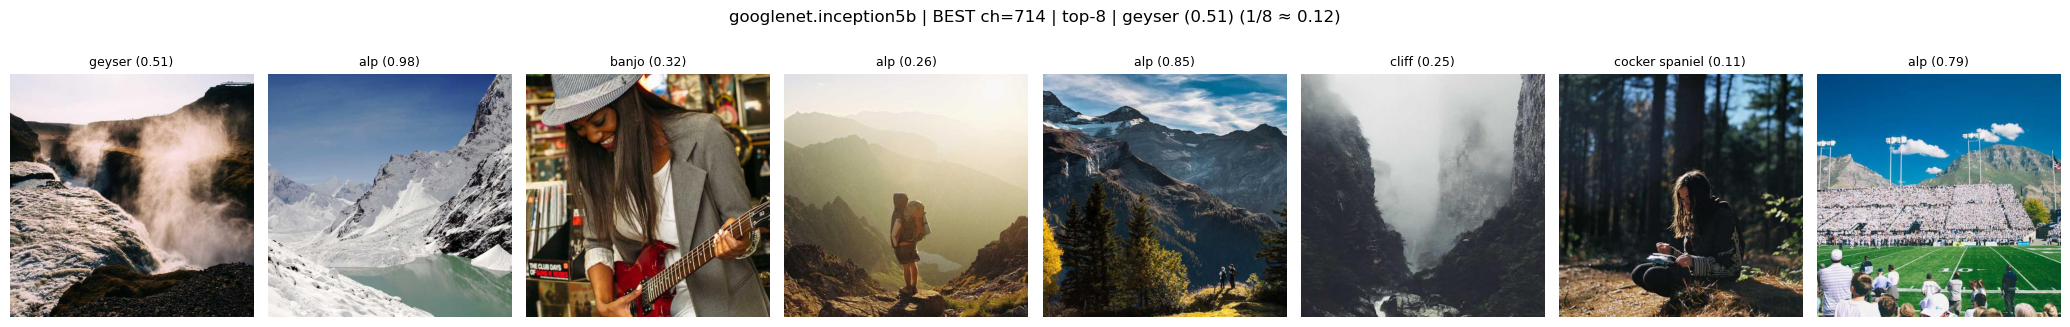

In [15]:

best = int(df.iloc[0]["channel"])
idx = topk_for_channel_unique(acts, best, k=8, paths=img_paths, key="hash")
p = [img_paths[i] for i in idx]
labs = [f"{pred_labels[i]} ({pred_scores[i]:.2f})" for i in idx]
top_class, cnt, frac = mono_summary(labs)
title = f"googlenet.inception5b | BEST ch={best} | top-8 | {top_class} ({cnt}/8 ≈ {frac:.2f})"
panel(p, labs, title, save="monosemantic_best.png")


In [20]:

# Quick sanity check: verify idx->(path,label,score) alignment and uniqueness
def _sanity_check(ch_list=(0,1,2), k=8):
    for ch in ch_list:
        idx = topk_for_channel_unique(acts, ch, k=k, paths=img_paths, key="hash")
        P = [img_paths[i] for i in idx]
        L = [pred_labels[i] for i in idx]
        assert len(P) == len(set(P)), f"Duplicates remained for channel {ch}"
        assert all(isinstance(i, int) and 0 <= i < len(img_paths) for i in idx)
    print("Sanity check passed for", ch_list)

_sanity_check([int(df.iloc[i]['channel']) for i in range(3)])


Sanity check passed for [714, 91, 186]
